# PPP: Global Maps


To do: 1. annual mean predictability horizons, 2. max horizons, 3. range horizons

In [55]:
# Importing packages
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar
import re
from xmovie import Movie
%matplotlib inline
import imageio

In [8]:
gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

In [15]:
THRESHOLD = 0.235559205


In [76]:
npp_ppp = xr.open_dataset('/home/saumyam/nppppp.nc')
tos_ppp = xr.open_dataset('/home/saumyam/tosppp.nc')
sos_ppp = xr.open_dataset('/home/saumyam/sosppp.nc').where(sos_ppp > -100)
mld_ppp = xr.open_dataset('/home/saumyam/mldppp').where(mld_ppp > -100)
chlos_ppp = xr.open_dataset('/home/saumyam/chlosppp')

In [77]:
def coarse_ppp(driver, driver_ppp):
    annual = driver_ppp.coarsen(time=12).mean()
    coarse_months = xr.where(annual<THRESHOLD,annual.time,120).min(dim='time').where(grid['basin']!=0,np.NaN) # eventually replace this with 120 if it works
    coarse_months[driver].plot()
    return annual

Text(0.5, 1.0, 'Surface Chlorophyll, Annual Mean PPP')

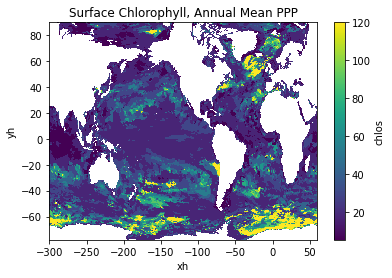

In [78]:
chlos_mean = coarse_ppp('chlos',chlos_ppp)
plt.title('Surface Chlorophyll, Annual Mean PPP')

Text(0.5, 1.0, 'Net Primary Production, Annual Mean PPP')

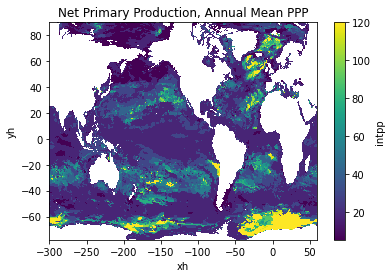

In [79]:
npp_mean = coarse_ppp('intpp',npp_ppp)
plt.title('Net Primary Production, Annual Mean PPP')

Text(0.5, 1.0, 'Sea Surface Temperature, Annual Mean PPP')

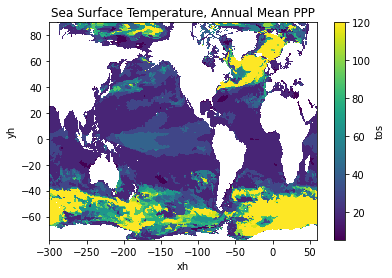

In [80]:
tos_mean = coarse_ppp('tos',tos_ppp)
plt.title('Sea Surface Temperature, Annual Mean PPP')


Text(0.5, 1.0, 'Sea Surface Salinity, Annual Mean PPP')

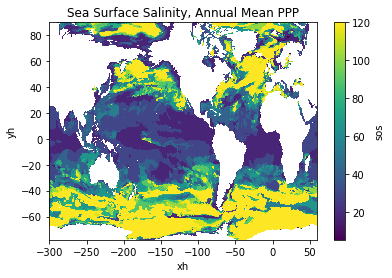

In [81]:
sos_mean = coarse_ppp('sos',sos_ppp)
plt.title('Sea Surface Salinity, Annual Mean PPP')


Text(0.5, 1.0, 'Mixed Layer Depth, Annual Mean PPP')

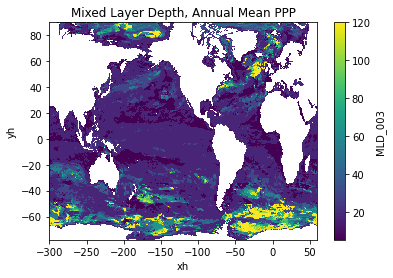

In [82]:
mld_mean = coarse_ppp('MLD_003',mld_ppp)
plt.title('Mixed Layer Depth, Annual Mean PPP')

In [ ]:
tos_ppp_mean = tos_ppp['tos'].weighted(grid['areacello']).mean(['xh','yh'])
with ProgressBar():
    tos_ppp_mean = tos_ppp_mean.compute()

In [ ]:
tos_ppp_mean.plot()

In [ ]:
tos_ppp['tos'].isel(time=50).plot()

In [ ]:
months = xr.where(tos_ppp<THRESHOLD,tos_ppp.time,120) # eventually replace this with 120 if it works

In [ ]:
max_months = xr.where(tos_ppp>THRESHOLD,tos_ppp.time,np.NaN) # eventually replace this with 120 if it works

In [ ]:
max_npp = xr.where(npp_ppp>THRESHOLD,npp_ppp.time,np.NaN).max(dim='time').where(grid['basin']!=0,np.NaN)

In [ ]:
max_npp['intpp'].plot()

In [ ]:
min_month = months.min(dim='time')

In [ ]:
min_month = min_month.where(grid['basin']!=0,np.NaN)

In [ ]:
max_month = max_months.max(dim='time')

In [ ]:
max_month = max_month.where(grid['basin']!=0,np.NaN)

In [ ]:
max_month['tos'].plot()

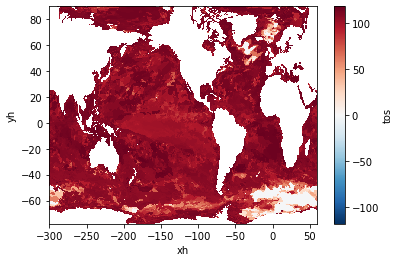

In [140]:
(max_month-min_month)['tos'].plot()

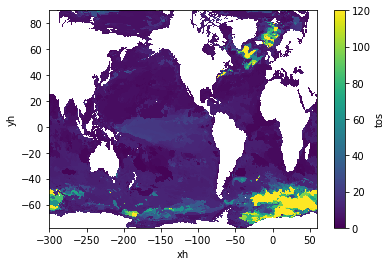

In [141]:
min_month['tos'].plot()

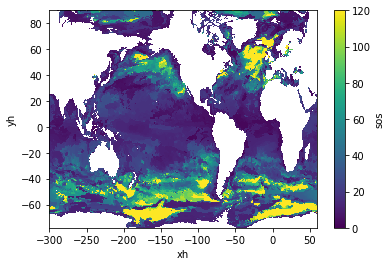

In [66]:
sos_months = xr.where(sos_ppp<THRESHOLD,sos_ppp.time,120) # eventually replace this with 120 if it works

sos_min_month = sos_months.min(dim='time')

sos_min_month = sos_min_month.where(grid['basin']!=0,np.NaN)

sos_min_month['sos'].plot()

In [67]:
npp_months = xr.where(npp_ppp<THRESHOLD,npp_ppp.time,60)
min_npp_month = npp_months.min(dim='time')

In [68]:
min_npp_month

<xarray.Dataset>
Dimensions:  (yh: 576, xh: 720, nv: 2)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * nv       (nv) float64 1.0 2.0
Data variables:
    intpp    (yh, xh) int64 60 60 60 60 60 60 60 60 ... 60 60 60 60 60 60 60 60

In [69]:
new = min_npp_month.where(grid['basin']!=0,np.NaN)

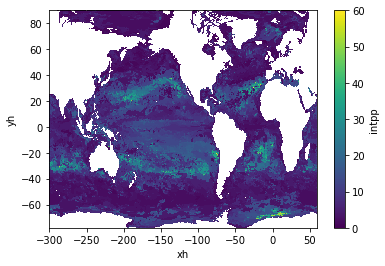

In [70]:
new['intpp'].plot()

In [1]:
# minor helper method - returns the ppname for a particular driver
def pp(driver):
    if driver=='tos' or driver=='sos' or driver=='MLD_003':
        return 'ocean_month'
    elif re.search('intpp*',driver):
        return 'ocean_cobalt_omip_2d'
    elif driver=='chlos':
        return 'ocean_cobalt_omip_sfc'

In [2]:
# can try using positional args: https://xarray.pydata.org/en/stable/generated/xarray.where.html

In [3]:
# returns the variance for a particular ensemble start year
def ens_var(start_year, driver_global, driver):
    # create a list of xarrays of control + ensemble data to be concatenated
    members = [*range(10)]
    ppname = pp(driver)
    
    # handle the control separately
    end = '0' + str(int(start_year) + 9)
    ctrl_slice = driver_global.sel(time=slice(start_year+'-01-16',end+'-12-16'))
    members[0] = ctrl_slice
    
    # loop through all 9 ensemble members
    for member in range(1,10):
        folder = 'ESM4_piControl_D-ensemble-' + start_year + '0101-0' + str(member)
        path = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/'
                +folder+'/gfdl.ncrc4-intel18-prod-openmp/pp/'+ppname+'/ts/monthly/5yr/'+ppname+'.*'+driver+'.nc')
        ens_mem = xr.open_mfdataset(path)
        members[member] = ens_mem
        
    # combine all ensemble members and control into one xarray
    all_members = xr.concat(members,dim='members')
    
    # compute the variance
    variance = (all_members.std(dim='members')) ** 2
    
    return variance
    


In [4]:
STARTS = ['0123','0161','0185','0208','0230','0269','0300','0326','0359','0381']
def avg_ens_var(driver_global, driver):
    # initialize total to be stddev of first ensemble - year '0123'
    
    ensembles = [*range(10)]
    first = ens_var(STARTS[0],driver_global,driver)
    timei = first.time
    ensembles[0] = first
    
    for ens in range(1,10):
        time_adjusted = ens_var(STARTS[ens],driver_global,driver).assign_coords(time=timei)
        ensembles[ens] = time_adjusted
    
    total = xr.concat(ensembles,dim='ensemble')
    avg = total.mean(dim='ensemble')
    
    return avg


## Plotting

In [37]:
ppp = xr.open_dataset('/home/saumyam/tosppp.nc')

In [38]:
southern = ppp.where(grid['basin']==1,drop=True)

In [39]:
atlantic = ppp.where(grid['basin']==2,drop=True)
atlantic_mean = atlantic['tos'].weighted(grid['areacello']).mean(['xh','yh'])
with ProgressBar():
    atlantic_mean = atlantic_mean.compute()

In [40]:
indian = ppp.where(grid['basin']==5,drop=True)
indian_mean = indian['tos'].weighted(grid['areacello']).mean(['xh','yh'])
with ProgressBar():
    indian_mean = indian_mean.compute()

In [41]:
pacific = ppp.where(grid['basin']==3,drop=True)
pacific_mean = pacific['tos'].weighted(grid['areacello']).mean(['xh','yh'])
with ProgressBar():
    pacific_mean = pacific_mean.compute()

In [42]:
arctic = ppp.where(grid['basin']==4,drop=True)
arctic_mean = arctic['tos'].weighted(grid['areacello']).mean(['xh','yh'])
with ProgressBar():
    arctic_mean = arctic_mean.compute()

In [43]:
southern_mean = (southern['tos'].weighted(grid['areacello']).mean(['xh','yh']))

In [44]:
with ProgressBar():
    southern_mean = southern_mean.compute()

In [45]:
ppp_mean = ppp['tos'].weighted(grid['areacello']).mean(['xh','yh'])
with ProgressBar():
    ppp_mean = ppp_mean.compute()

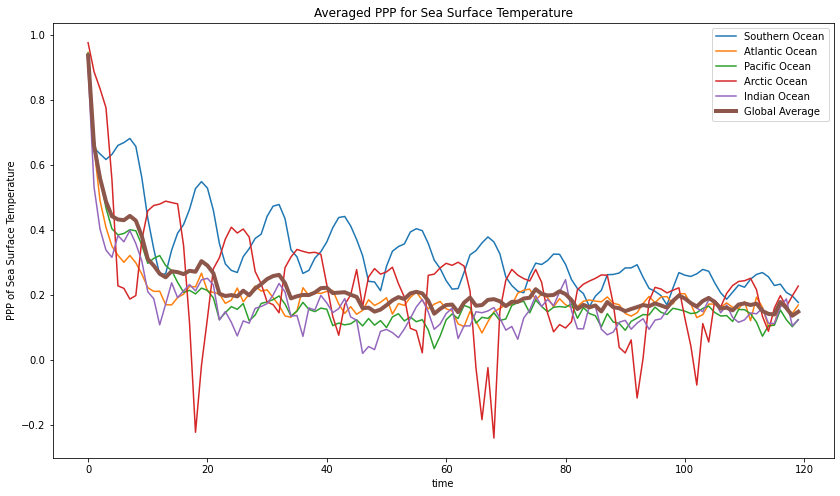

In [46]:
figure(figsize=(14,8))
southern_mean.plot(label='Southern Ocean')
atlantic_mean.plot(label='Atlantic Ocean')
pacific_mean.plot(label='Pacific Ocean')
arctic_mean.plot(label='Arctic Ocean')
indian_mean.plot(label='Indian Ocean')
ppp_mean.plot(linewidth=4,label='Global Average')
plt.ylabel('PPP of Sea Surface Temperature')
plt.title('Averaged PPP for Sea Surface Temperature')
plt.legend()

In [47]:
ppp_mean

<xarray.DataArray 'tos' (time: 120)>
array([0.9358704 , 0.6579256 , 0.55858815, 0.48668313, 0.44116327,
       0.43150145, 0.42913812, 0.4424394 , 0.42782953, 0.380328  ,
       0.30982554, 0.28949898, 0.26445735, 0.25353116, 0.27215278,
       0.269404  , 0.26337847, 0.27360457, 0.27051032, 0.30326474,
       0.28983232, 0.26576427, 0.20312227, 0.19588824, 0.19889444,
       0.19480851, 0.21227539, 0.1983832 , 0.219075  , 0.2323383 ,
       0.24815145, 0.25733364, 0.2610848 , 0.23551221, 0.18867163,
       0.19520676, 0.19929186, 0.1988863 , 0.2066239 , 0.22006203,
       0.22139536, 0.20501989, 0.20640117, 0.20763478, 0.19995758,
       0.19312733, 0.15842986, 0.16016868, 0.14797606, 0.15422015,
       0.16767427, 0.18276152, 0.1925205 , 0.18672568, 0.20409127,
       0.20887043, 0.20405981, 0.18158618, 0.14141992, 0.15639085,
       0.16818719, 0.16963358, 0.14614525, 0.17566772, 0.19108279,
       0.16611633, 0.16808063, 0.18407565, 0.18629919, 0.17975615,
       0.1649514 , 0.17812733, 0.17819613, 0.18824068, 0.19066617,
       0.21697597, 0.20271619, 0.1976344 , 0.19925071, 0.21059093,
       0.20183438, 0.18364525, 0.15594701, 0.16876519, 0.16105014,
       0.16688816, 0.14851175, 0.17755161, 0.16160281, 0.1582729 ,
       0.14944841, 0.15598251, 0.16184594, 0.1682651 , 0.16450216,
       0.17319049, 0.16699   , 0.16006874, 0.18116993, 0.19719316,
       0.18845958, 0.17415749, 0.16369359, 0.18074413, 0.1901249 ,
       0.17740384, 0.15746228, 0.16016777, 0.15175052, 0.1697403 ,
       0.17325915, 0.16829851, 0.17266513, 0.14998157, 0.14095671,
       0.13916595, 0.17773537, 0.15912515, 0.1353026 , 0.14760758],
      dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119

### Packaged into one function that just takes the driver name as input:

In [5]:
# returns xarray of ppp
def ppp(driver):
    ds = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Full/'+driver)
    ds = ds.chunk({'time':60})
    
    avg_ens = avg_ens_var(ds,driver)
    with ProgressBar():
        avg_ens = avg_ens.compute()
    timeindex = np.arange(120)
    avg_ens = avg_ens.assign_coords(time=timeindex)
    
    control_monthly = ds[driver].groupby('time.month')
    control_var_monthly = control_monthly.std() ** 2
    control_var_arr = control_var_monthly.to_numpy()
    repeated = np.tile(control_var_arr, (10,1,1))
    #xarray.repeat
    
    ctrl_var = avg_ens.copy(data={driver:repeated})
    ctrl_var = ctrl_var.assign_coords(time=timeindex)
    
    ratio = avg_ens / ctrl_var
    ppp = 1 - ratio
    return ppp

In [9]:
chlos_ppp = ppp('chlos')

[###                                     ] | 9% Completed |  3.6s

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 52.5s


/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
mld_ppp = ppp('MLD_003')

[####                                    ] | 10% Completed |  4.4s

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 56.0s


/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [11]:
chlos_ppp.to_netcdf('/home/saumyam/chlosppp')
mld_ppp.to_netcdf('/home/saumyam/mldppp')

In [ ]:
sosppp = ppp('sos')

In [ ]:
sosppp.to_netcdf('/home/saumyam/sosppp')

In [22]:
sosppp = xr.open_dataset('/home/saumyam/sosppp.nc')

In [21]:
# e.g. driver = 'tos', driver_name = 'Sea Surface Temperature'
def plot_basins(ppp, driver, driver_name, adjust=False):
    if adjust:
        ppp = ppp.where(ppp[driver] > -100)

    means = [*range(5)]
    for i in range(1,6):
        basin = ppp.where(grid['basin']==i,drop=True)
        means[i-1] = (basin[driver].weighted(grid['areacello']).mean(['xh','yh']))

    ppp_mean = ppp[driver].weighted(grid['areacello']).mean(['xh','yh'])

    labels = ['Southern Ocean', 'Atlantic Ocean', 'Pacific Ocean', 'Arctic Ocean', 'Indian Ocean']
    figure(figsize=(14,8))
    for i in range(5):
        means[i].plot(label=labels[i])
   
    ppp_mean.plot(linewidth=4,label='Global Average')
    plt.ylabel('PPP of ' + driver_name)
    plt.title('Averaged PPP of ' + driver_name)
    plt.legend()
    
    return ppp_mean

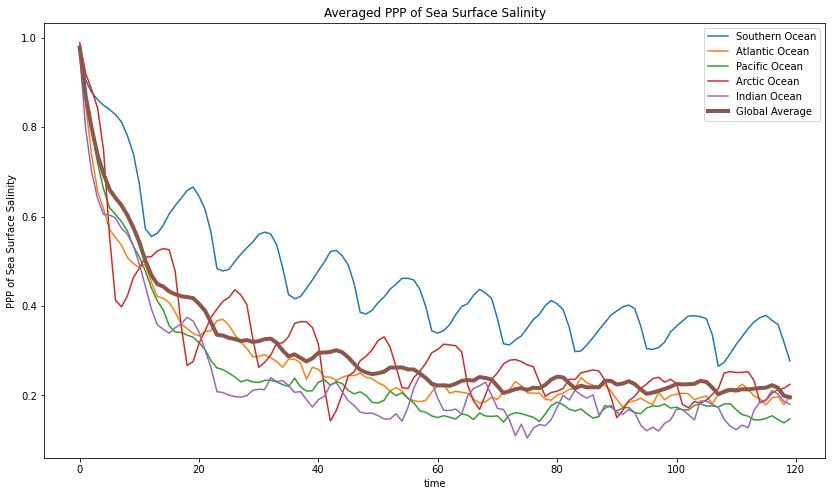

In [31]:
sos_ppp_mean = plot_basins(sos_ppp, 'sos', 'Sea Surface Salinity',adjust=True)

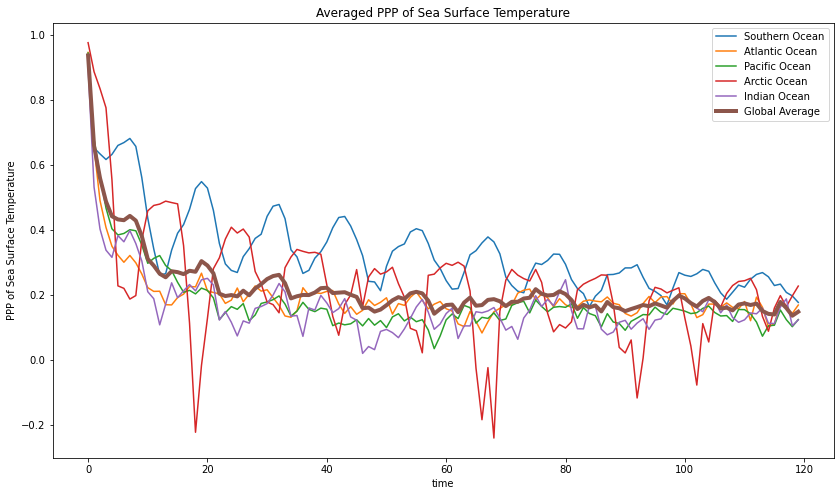

In [32]:
tos_ppp_mean = plot_basins(tos_ppp, 'tos', 'Sea Surface Temperature')

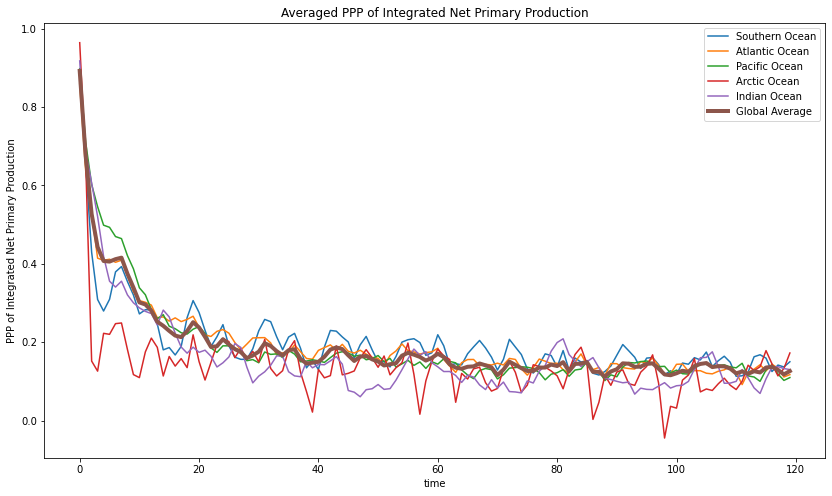

In [33]:
npp_ppp_mean = plot_basins(npp_ppp,'intpp','Integrated Net Primary Production')

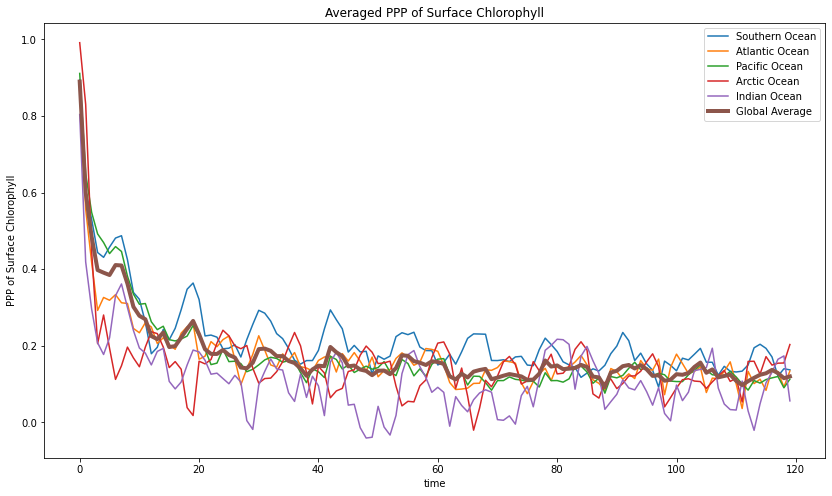

In [34]:
chlos_ppp_mean = plot_basins(chlos_ppp,'chlos','Surface Chlorophyll')

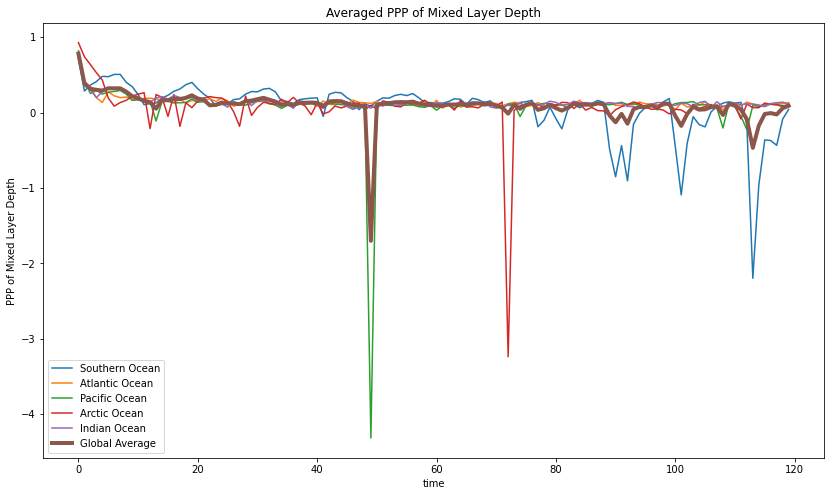

In [35]:
mld_ppp_mean = plot_basins(mld_ppp,'MLD_003','Mixed Layer Depth',adjust=False)
plt.savefig('PPP MLD OLD')

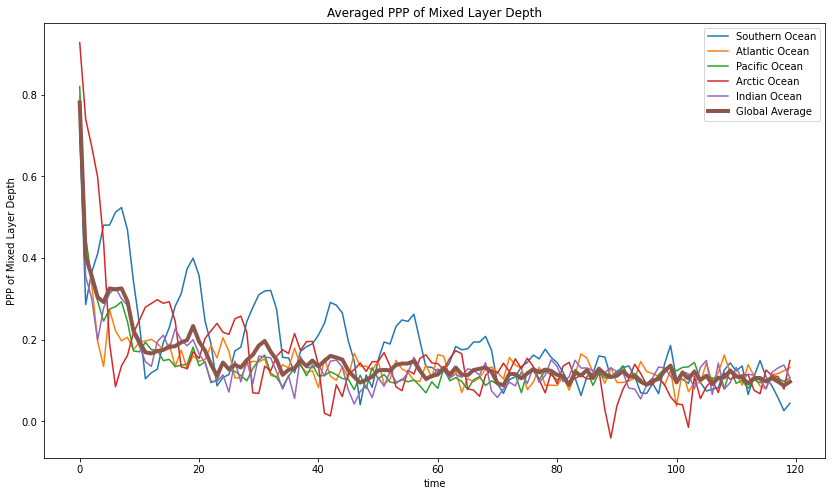

In [36]:
mld_ppp_mean = plot_basins(mld_ppp,'MLD_003','Mixed Layer Depth',adjust=True)

In [84]:
annuals = [tos_mean,sos_mean,mld_mean,npp_mean,chlos_mean]
drivers = ['tos','sos','MLD_003','intpp','chlos']
annuals_global = [*range(5)]

for i in range(len(annuals)):
    annuals_global[i] = annuals[i][drivers[i]].weighted(grid['areacello']).mean(['xh','yh'])
    
COLORS = ['green','orange','red','blue','purple']

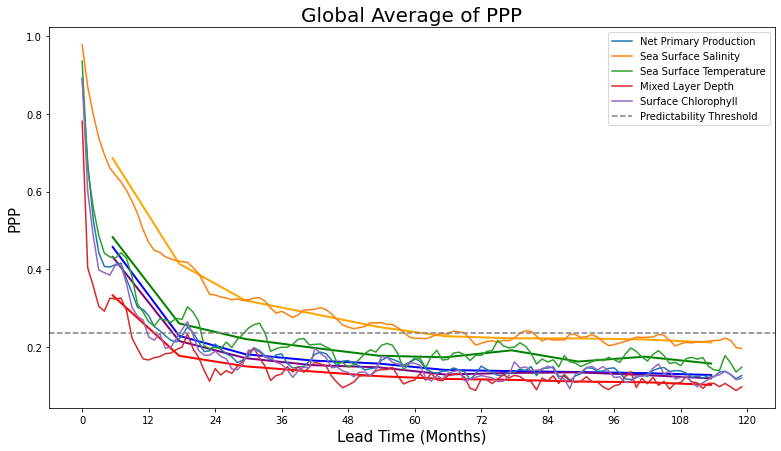

In [89]:

fig,ax = plt.subplots(1,1,figsize=(13,7))
months=[0,12,24,36,48,60,72,84,96,108,120]
ax.set_xticks(months)

for i in range(len(annuals_global)):
    annuals_global[i].plot(color=COLORS[i],linewidth=2)

npp_ppp_mean.plot(label='Net Primary Production')
sos_ppp_mean.plot(label='Sea Surface Salinity')
tos_ppp_mean.plot(label='Sea Surface Temperature')
mld_ppp_mean.plot(label='Mixed Layer Depth')
chlos_ppp_mean.plot(label='Surface Chlorophyll')
plt.axhline(y=THRESHOLD, color='grey', linestyle='dashed',label='Predictability Threshold')
plt.title('Global Average of PPP',fontsize=20)
plt.xlabel('Lead Time (Months)',fontsize=15)
plt.ylabel('PPP',fontsize=15)
plt.legend()
plt.savefig('Globally Averaged PPP-5 drivers')

In [96]:
chlos_ppp_mean

<xarray.DataArray 'chlos' (time: 120)>
array([0.8900066 , 0.60012823, 0.48492032, 0.3977813 , 0.39093965,
       0.3848597 , 0.41084385, 0.409736  , 0.36224148, 0.30184588,
       0.27834827, 0.26922983, 0.22534671, 0.21733822, 0.23473702,
       0.19665167, 0.19926144, 0.22145082, 0.2441599 , 0.2649498 ,
       0.23021033, 0.19083904, 0.17884715, 0.17864469, 0.18911298,
       0.17607656, 0.16926841, 0.14321359, 0.14121307, 0.15571463,
       0.19130482, 0.192642  , 0.18692349, 0.17305055, 0.17297195,
       0.16030122, 0.15499423, 0.14088805, 0.12174966, 0.13828516,
       0.14805746, 0.14655243, 0.19697052, 0.18309781, 0.1728843 ,
       0.14628963, 0.14841355, 0.13795547, 0.13435139, 0.12322494,
       0.13474774, 0.13537139, 0.1257182 , 0.14178361, 0.17508562,
       0.17376858, 0.15984333, 0.15591067, 0.14986686, 0.15953511,
       0.15770155, 0.15239668, 0.12024641, 0.11210939, 0.12688649,
       0.1171808 , 0.13249421, 0.13671915, 0.13969924, 0.11274727,
       0.11691718, 0.12186317, 0.12613617, 0.12326838, 0.12000865,
       0.11094681, 0.11167787, 0.12699461, 0.1616704 , 0.14566886,
       0.14860208, 0.1389341 , 0.14019385, 0.14195718, 0.15014417,
       0.14472963, 0.11957502, 0.11748035, 0.09212636, 0.13017674,
       0.13471517, 0.14676984, 0.14989482, 0.14076072, 0.14945252,
       0.13843185, 0.12134136, 0.12299784, 0.10875938, 0.11135288,
       0.12583296, 0.1242655 , 0.12884904, 0.14471641, 0.15622522,
       0.12957534, 0.13823108, 0.11762451, 0.12118373, 0.12474146,
       0.10826714, 0.09729625, 0.10758441, 0.11624651, 0.12425572,
       0.12818405, 0.13704655, 0.12856461, 0.11537082, 0.11988243],
      dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119

In [ ]:
npp_ppp.to_netcdf('/home/saumyam/nppppp')

# GIFs

In [45]:
sosmov = Movie(sos_ppp['sos'],vmin=0,vmax=1)
sosmov.save('sosppp.gif',gif_framerate=8)

Movie created at sosppp.mp4
GIF created at sosppp.gif


In [46]:
#tos_ppp = xr.open_dataset('/home/saumyam/tosppp.nc')
tosmov = Movie(tos_ppp['tos'],vmin=0,vmax=1)

In [48]:
tosmov.save('tosppp.gif',gif_framerate=8)

Movie created at tosppp.mp4
GIF created at tosppp.gif


In [51]:
nppmov = Movie(npp_ppp['intpp'],vmin=0,vmax=1)
nppmov.save('nppppp.gif',gif_framerate=8)

Movie created at nppppp.mp4
GIF created at nppppp.gif


In [53]:
mldmov = Movie(mld_ppp['MLD_003'],vmin=0,vmax=1)
mldmov.save('mldppp.gif',gif_framerate=8)

Movie created at mldppp.mp4
GIF created at mldppp.gif


In [54]:
chlosmov = Movie(chlos_ppp['chlos'],vmin=0,vmax=1)
chlosmov.save('chlosppp.gif',gif_framerate=8)

Movie created at chlosppp.mp4
GIF created at chlosppp.gif


In [60]:
# Combining the gifs
# Code Source: https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
#Create reader object for the gif
gif1 = imageio.get_reader('tosppp.gif')
gif2 = imageio.get_reader('nppppp.gif')
gif3 = imageio.get_reader('sosppp.gif')
gif4 = imageio.get_reader('chlosppp.gif')
#gif5 = imageio.get_reader('mldppp.gif')

#If they don't have the same number of frame take the shorter
number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#Create writer object
new_gif = imageio.get_writer('output.gif')

for frame_number in range(number_of_frames):
    img1 = gif1.get_next_data()
    img2 = gif2.get_next_data()
    img3 = gif3.get_next_data()
    img4 = gif4.get_next_data()
    img5 = gif5.get_next_data()
    #here is the magic
    new_image = np.hstack((img1, img2))
    new_image2 = np.hstack((img3, img4))
    #newest = np.hstack((np.vstack((new_image, new_image2)), img5))
    new_gif.append_data(newest)

gif1.close()
gif2.close() 
gif3.close()
gif4.close()
gif5.close()
new_gif.close()


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 640 and the array at index 1 has size 320